In [2]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score
import copy

from src.train import trainModel

#from src.dataloader import getData,spliceDataset,h5pyDataset,collate_fn
from src.dataloader import get_GTEX_v8_Data,spliceDataset,h5pyDataset,getDataPointList,getDataPointListGTEX,DataPointGTEX
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d,kl_div_2d
from src.model import SpliceAI_10K
from src.evaluation_metrics import print_topl_statistics,cross_entropy_2d,kullback_leibler_divergence_2d
from src.gpu_metrics import run_bootstrap

In [3]:
!nvidia-smi

Mon Jul  8 10:35:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:31:00.0 Off |                    0 |
| N/A   36C    P0             37W /  250W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
#!pip install pickle5

In [5]:
rng = np.random.default_rng(23673)

In [6]:
#gtf = None

In [7]:
L = 32
N_GPUS = 3
k = 2
NUM_ACCUMULATION_STEPS=1
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = 16*k*N_GPUS

k = NUM_ACCUMULATION_STEPS*k

CL = 2 * np.sum(AR*(W-1))

In [7]:
data_dir = '/odinn/tmp/benediktj/Data/SplicePrediction-GTEX-V8'
setType = 'train'
annotation, gene_to_label, seqData = get_GTEX_v8_Data(data_dir, setType,'annotation_GTEX_v8.txt')

In [8]:
#for key in tqdm(gene_to_label.keys()):
#    for d_key in gene_to_label[key][0]:
#        gene_to_label[key][0][d_key] = 1
#    for d_key in gene_to_label[key][1]:
#        gene_to_label[key][1][d_key] = 1

In [8]:
# Maximum nucleotide context length (CL_max/2 on either side of the 
# position of interest)
# CL_max should be an even number
# Sequence length of SpliceAIs (SL+CL will be the input length and
# SL will be the output length)

SL=5000
CL_max=10000

In [9]:
assert CL_max % 2 == 0

In [11]:
train_gene, validation_gene = train_test_split(annotation['gene'].drop_duplicates(),test_size=.1,random_state=435)
annotation_train = annotation[annotation['gene'].isin(train_gene)]
annotation_validation = annotation[annotation['gene'].isin(validation_gene)]

In [12]:
#with open('{}/sparse_discrete_gene_label_data_{}.pickle'.format(data_dir,setType), 'rb') as handle:
#    gene_to_label_old = pickle.load(handle)

In [13]:
#for gene in gene_to_label_old.keys():
#    if len(gene_to_label[gene])==0:
#        gene_to_label[gene] = gene_to_label_old[gene]

In [14]:
train_dataset = spliceDataset(getDataPointListGTEX(annotation_train,gene_to_label,SL,CL_max,shift=SL))
val_dataset = spliceDataset(getDataPointListGTEX(annotation_validation,gene_to_label,SL,CL_max,shift=SL))
train_dataset.seqData = seqData
val_dataset.seqData = seqData

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE//2, shuffle=False, num_workers=16)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 4
hs = []
learning_rate= k*1e-4
gamma=0.5
temp = 1
#final_lr = 1e-5
#gamma = 1/(learning_rate/final_lr)**(1/5) 

Epoch (train) 1/4: 100%|██████████████████████████████| 1425/1425 [05:35<00:00,  4.25it/s, a_r=0.656, d_r=0.651, loss=0.000802]


epoch: 1/4, train loss = 0.000889


Epoch (val) 1/4: 100%|███████████████████████████████████| 306/306 [00:29<00:00, 10.37it/s, a_r=0.61, d_r=0.594, loss=0.000988]



Acceptor:
0.9956	0.7342	0.8571	0.9355	0.8221	0.9596	0.2082	0.0513	0.0139	14451	19682.0	19682

Donor:
0.9964	0.7336	0.858	0.9375	0.8215	0.9474	0.1840	0.0439	0.0112	14755	20114.0	20114
epoch: 1/4, val loss = 0.000832


Epoch (train) 2/4: 100%|███████████████████████████████| 1425/1425 [05:24<00:00,  4.39it/s, a_r=0.657, d_r=0.645, loss=0.00081]


epoch: 2/4, train loss = 0.000795


Epoch (val) 2/4: 100%|███████████████████████████████████| 306/306 [00:31<00:00,  9.79it/s, a_r=0.614, d_r=0.623, loss=0.00096]



Acceptor:
0.9954	0.7386	0.8648	0.9422	0.8281	0.9581	0.2110	0.0532	0.0143	14537	19682.0	19682

Donor:
0.9961	0.736	0.8667	0.9416	0.8271	0.9630	0.2796	0.0807	0.0223	14804	20114.0	20114
epoch: 2/4, val loss = 0.000808


Epoch (train) 3/4: 100%|██████████████████████████████| 1425/1425 [05:21<00:00,  4.43it/s, a_r=0.662, d_r=0.656, loss=0.000778]


epoch: 3/4, train loss = 0.000772


Epoch (val) 3/4: 100%|███████████████████████████████████| 306/306 [00:33<00:00,  9.11it/s, a_r=0.61, d_r=0.608, loss=0.000949]



Acceptor:
0.9963	0.7414	0.8675	0.943	0.8306	0.9597	0.1956	0.0468	0.0122	14593	19682.0	19682

Donor:
0.9965	0.7401	0.8691	0.9429	0.8293	0.9656	0.2231	0.0566	0.0144	14886	20114.0	20114
epoch: 3/4, val loss = 0.000799


Epoch (train) 4/4: 100%|███████████████████████████████| 1425/1425 [05:18<00:00,  4.47it/s, a_r=0.66, d_r=0.649, loss=0.000756]


epoch: 4/4, train loss = 0.000755


Epoch (val) 4/4: 100%|████████████████████████████████████| 306/306 [00:33<00:00,  9.11it/s, a_r=0.618, d_r=0.62, loss=0.00094]



Acceptor:
0.9959	0.7433	0.87	0.9445	0.8329	0.9584	0.2125	0.0532	0.0139	14630	19682.0	19682

Donor:
0.9967	0.7413	0.8707	0.9434	0.8314	0.9683	0.2580	0.0676	0.0166	14910	20114.0	20114
epoch: 4/4, val loss = 0.000789


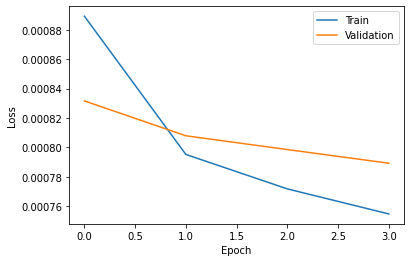

Epoch (train) 1/4: 100%|██████████████████████████████| 1425/1425 [05:21<00:00,  4.43it/s, a_r=0.652, d_r=0.652, loss=0.000804]


epoch: 1/4, train loss = 0.000881


Epoch (train) 2/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.47it/s, a_r=0.659, d_r=0.647, loss=0.000774]


epoch: 2/4, train loss = 0.000794


Epoch (train) 3/4: 100%|███████████████████████████████| 1425/1425 [05:17<00:00,  4.49it/s, a_r=0.659, d_r=0.65, loss=0.000759]


epoch: 3/4, train loss = 0.000772


Epoch (train) 4/4: 100%|███████████████████████████████| 1425/1425 [05:18<00:00,  4.47it/s, a_r=0.672, d_r=0.658, loss=0.00075]


epoch: 4/4, train loss = 0.000756


Epoch (train) 1/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.48it/s, a_r=0.651, d_r=0.646, loss=0.000823]


epoch: 1/4, train loss = 0.000879


Epoch (train) 2/4: 100%|██████████████████████████████| 1425/1425 [05:17<00:00,  4.49it/s, a_r=0.665, d_r=0.655, loss=0.000765]


epoch: 2/4, train loss = 0.000795


Epoch (train) 3/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.47it/s, a_r=0.654, d_r=0.645, loss=0.000763]


epoch: 3/4, train loss = 0.000773


Epoch (train) 4/4: 100%|██████████████████████████████| 1425/1425 [05:17<00:00,  4.49it/s, a_r=0.666, d_r=0.649, loss=0.000762]


epoch: 4/4, train loss = 0.000757


Epoch (train) 1/4: 100%|███████████████████████████████| 1425/1425 [05:18<00:00,  4.48it/s, a_r=0.65, d_r=0.643, loss=0.000812]


epoch: 1/4, train loss = 0.000879


Epoch (train) 2/4: 100%|██████████████████████████████| 1425/1425 [05:19<00:00,  4.46it/s, a_r=0.662, d_r=0.648, loss=0.000768]


epoch: 2/4, train loss = 0.000793


Epoch (train) 3/4: 100%|███████████████████████████████| 1425/1425 [05:18<00:00,  4.48it/s, a_r=0.651, d_r=0.654, loss=0.00077]


epoch: 3/4, train loss = 0.000772


Epoch (train) 4/4: 100%|██████████████████████████████| 1425/1425 [05:17<00:00,  4.49it/s, a_r=0.665, d_r=0.658, loss=0.000766]


epoch: 4/4, train loss = 0.000755


Epoch (train) 1/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.48it/s, a_r=0.654, d_r=0.655, loss=0.000804]


epoch: 1/4, train loss = 0.000882


Epoch (train) 2/4: 100%|██████████████████████████████| 1425/1425 [05:17<00:00,  4.49it/s, a_r=0.657, d_r=0.652, loss=0.000799]


epoch: 2/4, train loss = 0.000795


Epoch (train) 3/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.48it/s, a_r=0.664, d_r=0.651, loss=0.000764]


epoch: 3/4, train loss = 0.000772


Epoch (train) 4/4: 100%|███████████████████████████████| 1425/1425 [05:19<00:00,  4.47it/s, a_r=0.666, d_r=0.66, loss=0.000747]


epoch: 4/4, train loss = 0.000756


Epoch (train) 1/4: 100%|██████████████████████████████| 1425/1425 [05:19<00:00,  4.46it/s, a_r=0.648, d_r=0.641, loss=0.000829]


epoch: 1/4, train loss = 0.000889


Epoch (train) 2/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.47it/s, a_r=0.653, d_r=0.651, loss=0.000805]


epoch: 2/4, train loss = 0.000796


Epoch (train) 3/4: 100%|██████████████████████████████| 1425/1425 [05:19<00:00,  4.46it/s, a_r=0.657, d_r=0.647, loss=0.000782]


epoch: 3/4, train loss = 0.000772


Epoch (train) 4/4: 100%|██████████████████████████████| 1425/1425 [05:19<00:00,  4.46it/s, a_r=0.672, d_r=0.664, loss=0.000752]


epoch: 4/4, train loss = 0.000754


Epoch (train) 1/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.47it/s, a_r=0.644, d_r=0.634, loss=0.000811]


epoch: 1/4, train loss = 0.000885


Epoch (train) 2/4: 100%|██████████████████████████████| 1425/1425 [05:19<00:00,  4.46it/s, a_r=0.652, d_r=0.645, loss=0.000789]


epoch: 2/4, train loss = 0.000798


Epoch (train) 3/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.47it/s, a_r=0.663, d_r=0.655, loss=0.000784]


epoch: 3/4, train loss = 0.000775


Epoch (train) 4/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.47it/s, a_r=0.661, d_r=0.656, loss=0.000763]


epoch: 4/4, train loss = 0.000759


Epoch (train) 1/4: 100%|██████████████████████████████| 1425/1425 [05:19<00:00,  4.46it/s, a_r=0.645, d_r=0.647, loss=0.000821]


epoch: 1/4, train loss = 0.000886


Epoch (train) 2/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.48it/s, a_r=0.653, d_r=0.638, loss=0.000817]


epoch: 2/4, train loss = 0.000796


Epoch (train) 3/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.48it/s, a_r=0.662, d_r=0.656, loss=0.000764]


epoch: 3/4, train loss = 0.000771


Epoch (train) 4/4: 100%|███████████████████████████████| 1425/1425 [05:19<00:00,  4.47it/s, a_r=0.668, d_r=0.66, loss=0.000743]


epoch: 4/4, train loss = 0.000755


Epoch (train) 1/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.48it/s, a_r=0.649, d_r=0.646, loss=0.000827]


epoch: 1/4, train loss = 0.000880


Epoch (train) 2/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.47it/s, a_r=0.661, d_r=0.649, loss=0.000775]


epoch: 2/4, train loss = 0.000793


Epoch (train) 3/4: 100%|██████████████████████████████| 1425/1425 [05:19<00:00,  4.46it/s, a_r=0.667, d_r=0.659, loss=0.000769]


epoch: 3/4, train loss = 0.000770


Epoch (train) 4/4: 100%|███████████████████████████████| 1425/1425 [05:18<00:00,  4.47it/s, a_r=0.658, d_r=0.66, loss=0.000748]


epoch: 4/4, train loss = 0.000754


Epoch (train) 1/4: 100%|██████████████████████████████| 1425/1425 [05:19<00:00,  4.46it/s, a_r=0.651, d_r=0.645, loss=0.000807]


epoch: 1/4, train loss = 0.000877


Epoch (train) 2/4: 100%|██████████████████████████████| 1425/1425 [05:21<00:00,  4.44it/s, a_r=0.652, d_r=0.644, loss=0.000785]


epoch: 2/4, train loss = 0.000793


Epoch (train) 3/4: 100%|██████████████████████████████| 1425/1425 [05:18<00:00,  4.48it/s, a_r=0.663, d_r=0.652, loss=0.000771]


epoch: 3/4, train loss = 0.000770


Epoch (train) 4/4: 100%|██████████████████████████████| 1425/1425 [05:17<00:00,  4.48it/s, a_r=0.669, d_r=0.658, loss=0.000747]

epoch: 4/4, train loss = 0.000755


In [17]:
for model_nr in range(10):
    model_m = SpliceAI_10K(CL_max)
    model_m.apply(keras_init)
    model_m = model_m.to(device)
    if torch.cuda.device_count() > 1:
        #print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model_m = nn.DataParallel(model_m)
    
    model_m.load_state_dict(torch.load('../Results/PyTorch_Models/spliceai_encoder_10k_191022_{}'.format(model_nr)))
    modelFileName = '../Results/PyTorch_Models/spliceai_encoder_10k_GTEX_021222_{}'.format(model_nr)
    loss = categorical_crossentropy_2d().loss
    #loss = kl_div_2d(temp=temp).loss
    optimizer = torch.optim.AdamW(model_m.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    warmup = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=100)
    if model_nr>0:
        h = trainModel(model_m,modelFileName,loss,train_loader,val_loader,optimizer,scheduler,warmup,BATCH_SIZE,epochs,device,skipValidation=True,lowValidationGPUMem=True,NUM_ACCUMULATION_STEPS=NUM_ACCUMULATION_STEPS,CL_max=CL_max,reinforce=False,continous_labels=False)
    else:
        h = trainModel(model_m,modelFileName,loss,train_loader,val_loader,optimizer,scheduler,warmup,BATCH_SIZE,epochs,device,skipValidation=False,lowValidationGPUMem=True,NUM_ACCUMULATION_STEPS=NUM_ACCUMULATION_STEPS,CL_max=CL_max,reinforce=False,continous_labels=False)
        plt.plot(range(epochs),h['loss'],label='Train')
        plt.plot(range(epochs),h['val_loss'],label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    hs.append(h)

    

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h5f = h5py.File('/odinn/tmp/benediktj/SpliceAITrainingCode/dataset_test_0_10k.h5')

num_idx = len(h5f.keys())//2

test_dataset = h5pyDataset(h5f,list(range(num_idx)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceAI_10K(CL_max)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/spliceai_encoder_10k_GTEX_021222_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()
    
Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

for (batch_chunks,target_chunks) in tqdm(test_loader):
    batch_chunks = torch.transpose(batch_chunks[0].to(device),1,2)
    target_chunks = torch.transpose(torch.squeeze(target_chunks[0].to(device),0),1,2)
    #print(np.max(target_chunks.cpu().numpy()[:,2,:]))
    n_chunks = int(np.ceil(batch_chunks.shape[0]/BATCH_SIZE))
    batch_chunks = torch.chunk(batch_chunks, n_chunks, dim=0)
    target_chunks = torch.chunk(target_chunks, n_chunks, dim=0)
    targets_list = []
    outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        targets = target_chunks[j]
        outputs = ([models[i](batch_features).detach() for i in range(n_models)])
        #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
        outputs = torch.mean(torch.stack(outputs),dim=0)
        #outputs = odds_gmean(torch.stack(outputs))
        #outputs = (outputs[0]+outputs[1]+outputs[2])/n_models
        targets_list.extend(targets.unsqueeze(0))
        outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(torch.vstack(targets_list),1,2).cpu().numpy()
    outputs = torch.transpose(torch.vstack(outputs_list),1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())

100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:42<00:00, 10.14s/it]


In [21]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00046280436537960215

Acceptor:
0.995	0.9305	0.9844	0.9885	0.9684	0.9902	0.7589	0.1575	0.0407	13296	14289.0	14289

Donor:
0.9947	0.9349	0.9868	0.991	0.9721	0.9902	0.7683	0.1629	0.0417	13359	14289.0	14289


In [22]:
from src.dataloader import getData
setType = 'test'
annotation_test, transcriptToLabel_test, seqData = getData('/odinn/tmp/benediktj/Data/SplicePrediction-050422', setType)    

In [23]:
from src.dataloader import getDataPointListFull,DataPointFull

In [24]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceAI_10K(CL_max)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/spliceai_encoder_10k_GTEX_021222_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListFull(annotation_test,transcriptToLabel_test,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features).detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)
    #outputs = odds_gmean(outputs)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|██████████████████████████████████████████████████████████████████████████████████████| 1386/1386 [23:40<00:00,  1.02s/it]


In [25]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.0003201272902582534

Acceptor:
0.9799	0.9255	0.9885	0.9948	0.9583	0.9916	0.8257	0.1771	0.0503	83027	89712.0	89712

Donor:
0.9815	0.9302	0.9916	0.9964	0.9634	0.9916	0.8360	0.1814	0.0518	83451	89712.0	89712


In [10]:
setType = 'test'
data_dir = '/odinn/tmp/benediktj/Data/SplicePrediction-GTEX-V8'
annotation_test, gene_to_label, seqData = get_GTEX_v8_Data(data_dir, setType,'annotation_GTEX_v8.txt')

In [11]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceAI_10K(CL_max)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/spliceai_encoder_10k_GTEX_021222_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListGTEX(annotation_test,gene_to_label,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features).detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)
    #outputs = odds_gmean(outputs)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|██████████████████████████████████████████████████████████████████████████| 774/774 [14:55<00:00,  1.16s/it]


In [13]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.0006331044024737925

Acceptor:
0.9969	0.752	0.8861	0.958	0.844	0.9496	0.2297	0.0638	0.0171	67381	89600.0	89600

Donor:
0.9965	0.7499	0.8817	0.9521	0.8397	0.9468	0.2250	0.0633	0.0169	68448	91272.0	91272


In [12]:
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
run_bootstrap(Y_true_acceptor.astype(np.int8),Y_pred_acceptor.astype(np.float32),Y_true_donor.astype(np.int8),Y_pred_donor.astype(np.float32),n_bootstraps = 1000)

0.7509771758550581 0.8418720364570618


100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [21:19<00:00,  1.28s/it]

average precision score = 0.8418720364570618 (95% confidence interval: [0.8408718705177307, 0.8435793280601501])
topk score = 0.7509771758550581 (95% confidence interval: [0.7497158367084771, 0.7529747884794842])


In [14]:
#df = pd.DataFrame({'Y_true_acceptor':Y_true_acceptor,'Y_pred_acceptor':Y_pred_acceptor,'Y_true_donor':Y_true_donor,'Y_pred_donor':Y_pred_donor})
#df.to_csv('/odinn/tmp/benediktj/Data/SplicePrediction-GTEX-V8/spliceai_10k_test_set_predictions_120123.gz',index=False)

In [2]:
(0.752+0.7499)/2

0.75095

In [3]:
(0.844+0.8397)/2

0.84185

In [4]:
67381+68448

135829